In [1]:
import sys, os
BIN = os.path.expanduser("../../../")
sys.path.append(BIN)

import numpy as np
from scipy.constants import m_p, c, e, pi

import matplotlib.pyplot as plt
%matplotlib inline

import copy
import itertools

from PyHEADTAIL.trackers.simple_long_tracking import LinearMap
from PyHEADTAIL.particles.slicing import UniformBinSlicer
import PyHEADTAIL.particles.generators as generators
import PyHEADTAIL_feedback.processors as processors

np.random.seed(0)

PyHEADTAIL v1.9.4




In [2]:
class StepGenerator(object):
    def __init__(self,signal_function,t_window,frequency,points,amplitude,charge_spread):
        z_min = -1./(2.*frequency)*c
        z_max = (t_window-1./(2.*frequency))*c
        
        self.z_bins=np.linspace(z_min,z_max,points)
        self.mean_z = np.array([(i+j)/2. for i, j in zip(self.z_bins, self.z_bins[1:])])
        self.mean_x = amplitude*signal_function(self.mean_z*frequency/c)
        
        if charge_spread is not None:
            self.n_macroparticles_per_slice = 0.1*self.charge_dist(self.mean_z, charge_spread*c)

            for i, val in enumerate(self.n_macroparticles_per_slice):
                if val<1e-3:
                    self.n_macroparticles_per_slice[i]=0
        else:
            self.n_macroparticles_per_slice = np.ones(len(self.mean_z))
    
    def charge_dist(self, x, sig):
        return 1./(np.exp((-1.*x)/sig)+1.)
    
class SineStep(StepGenerator):
    def __init__(self,t_window,frequency,points,amplitude,charge_spread):
        super(self.__class__, self).__init__(self.signal_function,t_window,frequency,points,amplitude,charge_spread)
        
    def signal_function(self,x):
        signal=np.zeros(len(x))
        for i, val in enumerate(x):
            
            if val < 0:
                signal[i] = 0.
            else: 
                signal[i] = np.sin(val*2*pi)
        return signal

In [3]:
def pass_signal(signal_obj,processors):
    signal = signal_obj.mean_x
    for processor in processors:
        signal = processor.process(signal,signal_obj)
        
    return signal

In [4]:
def calculate_frequency_response(f_range,processors_ref, N_f = 100, N_signal = 400, start_point = 8.25):
    frequencies = np.logspace(np.log10(f_range[0]),np.log10(f_range[1]),N_f)
    response = []
    phase = []
    
    
    for i, f in enumerate(frequencies):
        p = int(float(i)/float(N_f)*100)
        sys.stdout.write("\r%d%%" % p)
        sys.stdout.flush()
        slice_set = SineStep(10.5*(1./f),f, N_signal,1.,None)
        signal = slice_set.mean_x
        signal_0 = copy.deepcopy(signal)
        processors = copy.deepcopy(processors_ref)
        for processor in processors:
            signal = processor.process(signal,slice_set)
        
        response.append(np.max(signal[(2*len(signal))/3:]))
        z_0 = 0.
        z_1 = 0.
        val_0_prev = 0.
        val_prev = 0.
        z_prev = 0.
        max_0  = np.max(signal_0[int(start_point*len(signal)/10.5):int((start_point+1.0)*len(signal)/10.5)])
        min_0  = np.min(signal_0[int(start_point*len(signal)/10.5):int((start_point+1.0)*len(signal)/10.5)])
        
        max_1  = np.max(signal[int(start_point*len(signal)/10.5):int((start_point+1.0)*len(signal)/10.5)])
        min_1  = np.min(signal[int(start_point*len(signal)/10.5):int((start_point+1.0)*len(signal)/10.5)])
        
        for z, val_0, val in zip(slice_set.mean_z[int(start_point*len(signal)/10.5):], signal_0[int(start_point*len(signal)/10.5):],
                              signal[int(start_point*len(signal)/10.5):]):
            if (z_0 == 0.) and (val_0 > (max_0+min_0)/2.):
                k = (val_0_prev-val_0)/(z_prev-z)
                b = val_0-k*z
                ref_val = (max_0+min_0)/2.
                z_0 = (ref_val-b)/k
                
            if (z_1 == 0.) and (val > (max_1+min_1)/2.):
                k = (val_prev-val)/(z_prev-z)
                b = val-k*z
                ref_val = (max_1+min_1)/2.
                z_1 = (ref_val-b)/k

            if (z_0 > 0.) and (z_1 > 0.):
                phase.append(360.*f*(z_0-z_1)/c)
                break
            val_0_prev = val_0
            val_prev = val
            z_prev = z
                
    return (frequencies,response,phase)
                
                
        
    

In [5]:
N_signal = 400
f_c = 1e9
f_signal = 1.*f_c

orginal_signal = SineStep(10.5*(1./f_signal),f_signal, N_signal,1.,None)

normal_lowpass = [
    processors.LowpassFilter(f_c)
]
normal_lowpass_signal = copy.deepcopy(orginal_signal)
normal_lowpass_signal = pass_signal(normal_lowpass_signal,normal_lowpass)


normal_highpass = [
    processors.HighpassFilter(f_c)
]
normal_highpass_signal = copy.deepcopy(orginal_signal)
normal_highpass_signal = pass_signal(normal_highpass_signal,normal_highpass)

pl_lowpass = [
    processors.PhaseLinearizedLowpass(f_c)
]
pl_lowpass_signal = copy.deepcopy(orginal_signal)
pl_lowpass_signal = pass_signal(pl_lowpass_signal,pl_lowpass)


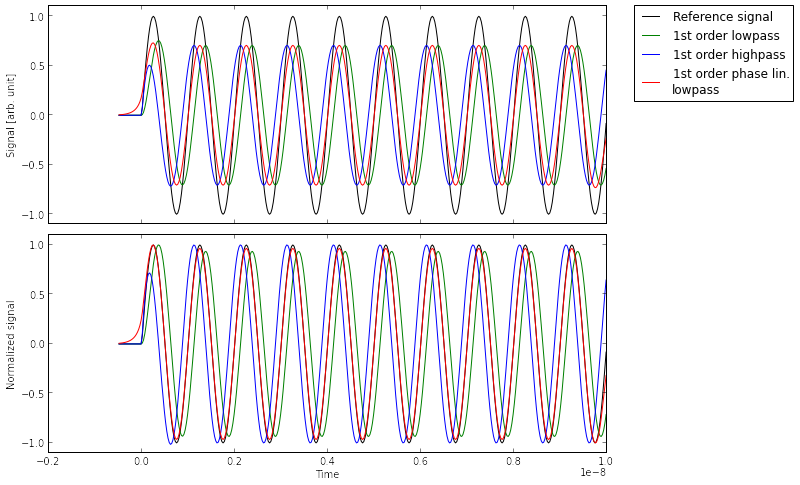

In [6]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)       
ax1.plot(orginal_signal.mean_z/c,orginal_signal.mean_x,'k-', label='Original signal')
ax1.plot(orginal_signal.mean_z/c,normal_lowpass_signal,'g-', label='1st order lowpass')
ax1.plot(orginal_signal.mean_z/c,normal_highpass_signal,'b-', label='1st order highpass')
ax1.plot(orginal_signal.mean_z/c,pl_lowpass_signal,'r-', label='1st order phase lin. \nlowpass')
ax1.set_xticklabels(())
ax1.title.set_visible(False)
ax1.set_ylabel('Signal [arb. unit]')
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax1.set_ylim([-1.1, 1.1])

ax2 = fig.add_subplot(212)       
ax2.plot(orginal_signal.mean_z/c,orginal_signal.mean_x,'k-')
ax2.plot(orginal_signal.mean_z/c,normal_lowpass_signal/float(np.max(normal_lowpass_signal)),'g-')
ax2.plot(orginal_signal.mean_z/c,normal_highpass_signal/float(np.max(normal_highpass_signal)),'b-')
ax2.plot(orginal_signal.mean_z/c,pl_lowpass_signal/float(np.max(pl_lowpass_signal)),'r-')
ax2.title.set_visible(False)
ax2.set_xlabel('Time')
ax2.set_ylabel('Normalized signal')
ax2.set_ylim([-1.1, 1.1])

fig.subplots_adjust(hspace = .05)

In [7]:
f_c = 100e6
processor_chain = [
    processors.LowpassFilter(f_c, norm_type = None)
]

results_normal_lowpass = calculate_frequency_response([1e-3*f_c,1e3*f_c],processor_chain, N_f = 30, start_point = 8.35)


96%

In [8]:
f_c = 100e6
processor_chain = [
    processors.HighpassFilter(f_c, norm_type = None)
]

results_normal_highpass = calculate_frequency_response([1e-3*f_c,1e3*f_c],processor_chain, N_f = 30, start_point = 8.15)


96%

In [9]:
f_c = 100e6
processor_chain = [
    processors.PhaseLinearizedLowpass(f_c, norm_type = None)
]

results_phase_lin_lowpass = calculate_frequency_response([1e-3*f_c,1e3*f_c],processor_chain, N_f = 30)


96%

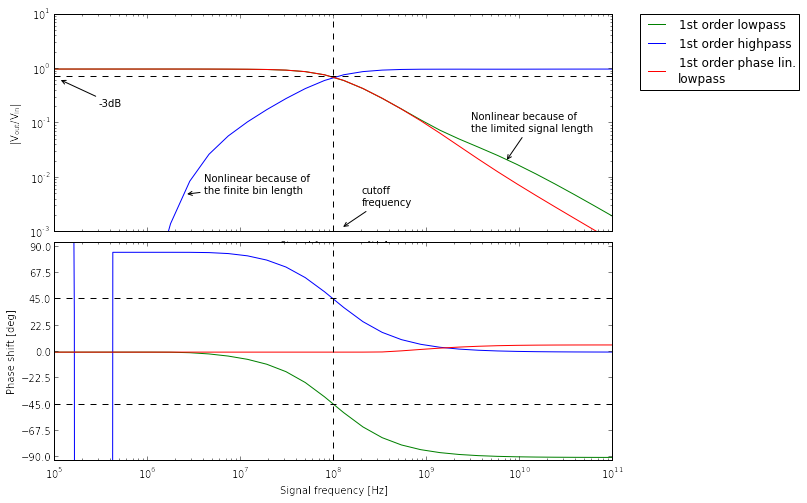

In [10]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)    
ax1.set_yscale("log")
ax1.set_xscale("log")

ax1.plot(results_normal_lowpass[0],results_normal_lowpass[1],'g-', label='1st order lowpass')
ax1.plot(results_normal_highpass[0],results_normal_highpass[1],'b-', label='1st order highpass')
ax1.plot(results_phase_lin_lowpass[0],results_phase_lin_lowpass[1],'r-', label='1st order phase lin. \nlowpass')
ax1.axhline(y=1/np.sqrt(2),c="black", ls='--')
ax1.axvline(x=1e8,c="black", ls='--')
# ax.axhline(y=0.5,xmin=10e5,xmax=10e11,c="blue",linewidth=0.5,zorder=0)
ax1.set_xlabel('Signal frequency [Hz]')
ax1.set_ylabel('|V$_{out}$/V$_{in}$|')
# ax1.legend(loc='upper right')
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


ax1.set_ylim([1e-3, 10])

ax1.annotate('cutoff\nfrequency', xy=(1.2e8, 1.2e-3), xytext=(2e8, 3e-3),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))

ax1.annotate('-3dB', xy=(1.1e5, 0.65), xytext=(3e5, 2e-1),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))

ax1.annotate('Nonlinear because of\nthe finite bin length', xy=(2.5e6, 0.5e-2), xytext=(4e6, 0.5e-2),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))
ax1.annotate('Nonlinear because of\nthe limited signal length', xy=(7e9, 2e-2), xytext=(3e9, 7e-2),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))
ax1.set_xticklabels(())
ax1.title.set_visible(False)


ax2 = fig.add_subplot(212)    
ax2.set_xscale("log")

ax2.plot(results_normal_lowpass[0],results_normal_lowpass[2],'g-', label='1st order lowpass')
ax2.plot(results_normal_highpass[0],results_normal_highpass[2],'b-', label='1st order highpass')
ax2.plot(results_phase_lin_lowpass[0],results_phase_lin_lowpass[2],'r-', label='1st order phase lin. \nlowpass')
ax2.axhline(y=-45.,c="black", ls='--')
ax2.axhline(y=45.,c="black", ls='--')
ax2.axvline(x=1e8,c="black", ls='--')
# ax.axhline(y=0.5,xmin=10e5,xmax=10e11,c="blue",linewidth=0.5,zorder=0)
ax2.set_xlabel('Signal frequency [Hz]')
ax2.set_ylabel('Phase shift [deg]')
ax2.set_yticks([-90, -67.5,-45,-22.5,0,22.5,45,67.5,90]) 
ax2.set_ylim([-93, 93])
ax2.title.set_visible(False)

fig.subplots_adjust(hspace = .05)